# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Load the clean data

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# load in the data
azdias = pd.read_parquet('data/clean/azdias.parquet')
customers = pd.read_parquet('data/clean/customers.parquet')
cat_cols = pd.read_csv('./data/clean/cat_cols.csv', header=None)

In [3]:
azdias.info()
print()
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 732798 entries, 910220 to 825787
Columns: 293 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: int16(5), int64(1), int8(285), object(2)
memory usage: 228.5+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131218 entries, 9626 to 148883
Columns: 296 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: int16(5), int64(1), int8(286), object(4)
memory usage: 43.0+ MB


# Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [4]:
def estimate_nbins(series, _max=25):
    """Estimates a suitable number of bins for a histogram, given a pandas.Series"""
    if pd.api.types.is_numeric_dtype(series.dtype):
        delta = max(2, series.max() - series.min() + 1)
    else:
        delta = len(series.unique())
        
    return min(delta, _max)

def plot_comparison(col, azdias=azdias, customers=customers):
    """Plots histograms of a specific column `col` for each of the provided dataframes"""
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)
    plt.title(col + ' Histogram')
    sns.histplot(azdias[col], color='red', bins=estimate_nbins(azdias[col]), alpha=0.4, stat="density", linewidth=0);
    sns.histplot(customers[col], bins=estimate_nbins(customers[col]), alpha=0.4, stat="density", linewidth=0);
    plt.legend(['General Population', 'Customers'])

    ax = plt.subplot(1, 2, 2)
    plt.title(col + ' Boxplot')
    pd.concat([customers[col], azdias[col]], axis=1).plot.box(ax=ax)
    plt.xticks(ticks=[1, 2], labels=['Customers', 'General Pop'])
        
    plt.show()

def plot_multiple_comparisons(col_list : list, azdias=azdias, customers=customers):
    """"""
    n_plots = len(col_list)
    fig = plt.figure(figsize=(12, 4 * n_plots))
    for i, col in enumerate(col_list):
        ax = plt.subplot(n_plots, 2, 2*i+1)
        plt.title(col + ' Histogram')
        sns.histplot(azdias[col], color='red', bins=estimate_nbins(azdias[col]), alpha=0.4, stat="density", linewidth=0);
        sns.histplot(customers[col], bins=estimate_nbins(customers[col]), alpha=0.4, stat="density", linewidth=0);
        plt.legend(['General Population', 'Customers'])

        ax = plt.subplot(n_plots, 2, 2*i+2)
        plt.title(col + ' Boxplot')
        if pd.api.types.is_numeric_dtype(customers[col].dtype):
            pd.concat([customers[col], azdias[col]], axis=1).plot.box(ax=ax)
            plt.xticks(ticks=[1, 2], labels=['Customers', 'General Pop'])
        else:
            ax.text(0.5, 0.5, 'No numerical data to plot.', fontSize=14, ha='center')
    
    fig.tight_layout()
    plt.show()


In [5]:
from scipy.stats import kstest

ks_results = []
for col in customers.columns:
    if col in azdias.columns:
        try:
            test_result = kstest(azdias[col], customers[col])
        except Exception as e:
            print(e)
            print(col)
            
        ks_results.append(
            {'feature': col, 
            'ks_score': test_result.statistic, 
            'ks_pvalue': test_result.pvalue
            })

ks_results = pd.DataFrame(ks_results)
ks_results = ks_results.sort_values('ks_score', ascending=False)

In [6]:
dias_atts = pd.read_csv('data/clean/dias_atts.csv')
info_levels = pd.read_csv('data/clean/info_levels.csv')

In [7]:
def get_feature_desc(feat):
    """
    Returns a feature's description based on the dias_attributes file.
    *Note:* Returns `None` if the feature is not present in the `dias_atts` dataframe
    """
    out = None
    if feat in dias_atts['Attribute'].values:
        out = dias_atts[dias_atts['Attribute'] == feat]['Description'].values[0]
    
    return out

ks_results['description'] = ks_results['feature'].map(get_feature_desc)

In [8]:
ks_results.head(-1)

,feature,ks_score,ks_pvalue,description
24,D19_KONSUMTYP_MAX,0.490883,0.000000,None
286,VK_ZG11,0.458630,0.000000,None
37,FINANZ_VORSORGER,0.432254,0.000000,financial typology: be prepared
35,FINANZ_SPARER,0.431149,0.000000,financial typology: money saver
253,PRAEGENDE_JUGENDJAHRE,0.420814,0.000000,dominating movement in the person's youth (ava...
...,...,...,...,...
28,DSL_FLAG,0.005117,0.005868,None
2,ALTER_KIND2,0.001877,0.827114,None
275,SOHO_KZ,0.001366,0.985398,small office/home office flag
27,D19_VERSI_ONLINE_DATUM,0.001169,0.998023,None


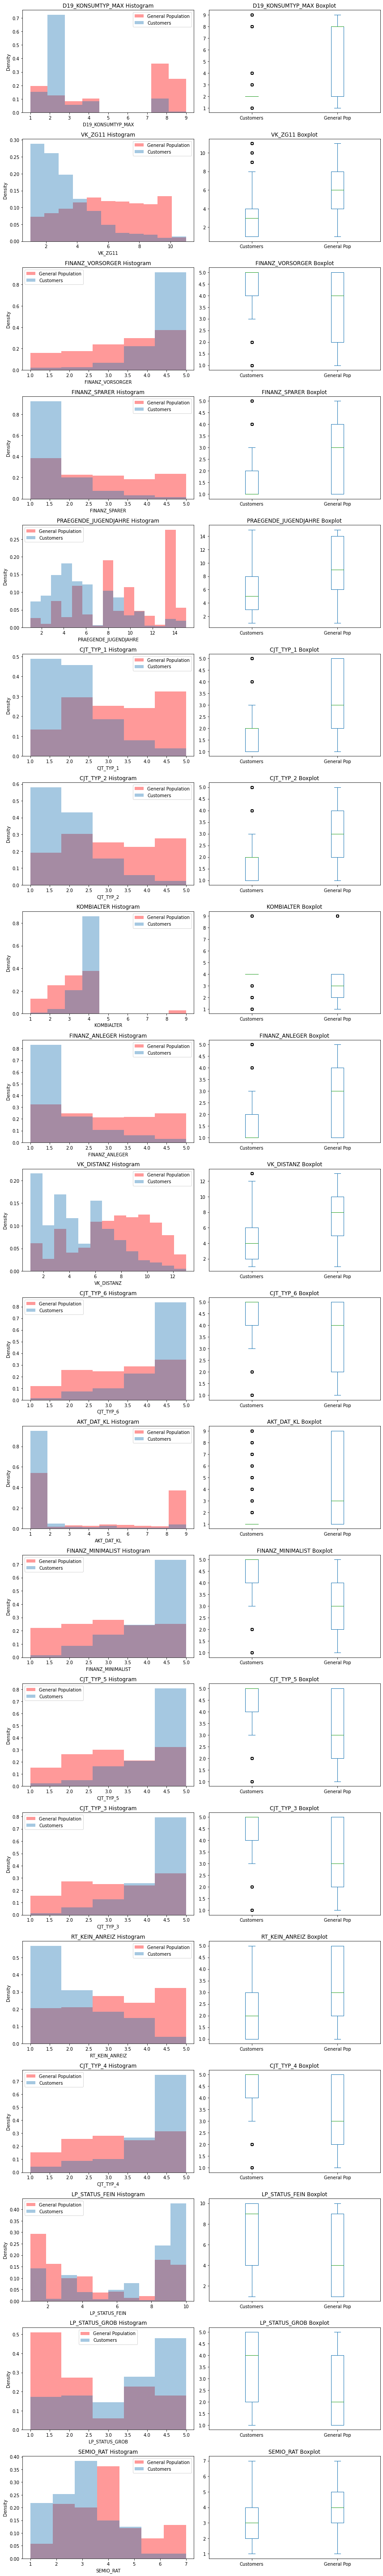

In [9]:
# Top 30 most dissimilar distributions (KS Test)
plot_multiple_comparisons(ks_results.head(20)['feature'].tolist())

From the top 20 most dissimilar distributions we can start to build an understanding of the customers in relation to the general population:
- Attributes such as `LP_STATUS` indicate a well-off customer base, in relation to the wealth of the general population.
- The `FINANZ` type features indicate the customers rank low on the "be prepared" and "low financial interest" categories, while ranking high on "money saver" and "investor".
- The `SEMIO` features indicate customers score high on categories such as rational and critical , traditional and dutyfull traditional, while having low affinity to the sensual-minded attitude.
- `ALTERSKATEGORIE_GROB` and `PRAEGENDE_JUGENDJAHRE` indicates customers of this company are on the older side of the general public (>60 years old)
- The custome journey features `CJT_TYP` show very pronounced trends towards specific journeys in comparison to the general public.

These visualizations aid in understanding key differences between customers as a group in contrast to the general population, but it does not provide us with a segmentation within the customers group. In the next sections we'll address this issue with more thorough procedures.

# Population and customer segmentation

## Dimensionality Reduction
We'll start the process by one-hot encoding every categorical feature in our dataset (as listed in the `cat_cols.csv` file created in the previous notebook) and performing Principal Component Analysis to reduce the data dimensionality.

**Note**: `cat_cols.csv` does not include categorical features available only in the `customers` dataset, only those present both in `azdias` and `customers`.

In [10]:
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score

In [11]:
print(f'There are {azdias.shape[1]} features in the dataset')

There are 293 features in the dataset


In [12]:
pca_pipeline = Pipeline([
    ('col_transformer', ColumnTransformer([
        ('one_hot', OneHotEncoder(), cat_cols[0].tolist())
    ], remainder='passthrough')),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(random_state=42))
])

pca_pipeline.fit(azdias)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  ['ANREDE_KZ',
                                                   'CAMEO_DEU_2015',
                                                   'CAMEO_INTL_2015',
                                                   'CJT_GESAMTTYP', 'FINANZTYP',
                                                   'GEBAEUDETYP',
                                                   'GEBAEUDETYP_RASTER',
                                                   'GREEN_AVANTGARDE',
                                                   'HEALTH_TYP',
                                                   'KBA05_HERSTTEMP',
                                                   'KBA05_MAXHERST',
                                                   'KBA05_MODTEMP',
                                                   'KBA05_SE

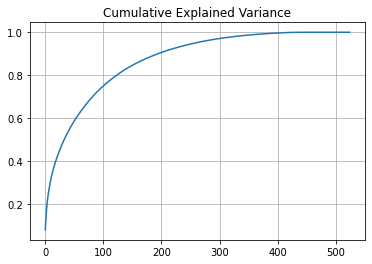

In [14]:
pca = pca_pipeline.steps[-1][1]
explained_variance_ratio = pd.Series(pca.explained_variance_ratio_, name='explained_variance')
explained_variance_ratio.cumsum().plot();
plt.title('Cumulative Explained Variance');
plt.grid('on');


In [16]:
n_components = explained_variance_ratio[explained_variance_ratio.cumsum() >= 0.8].index[0] + 1
print(f'The first {n_components} components explain 80% of the variance in the dataset')

The first 125 components explain 80% of the variance in the dataset


In [18]:
# Recalculate PCs with n_components as a parameter
pca_pipeline.steps[-1][1].n_components = n_components
pca_pipeline.fit(azdias)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  ['ANREDE_KZ',
                                                   'CAMEO_DEU_2015',
                                                   'CAMEO_INTL_2015',
                                                   'CJT_GESAMTTYP', 'FINANZTYP',
                                                   'GEBAEUDETYP',
                                                   'GEBAEUDETYP_RASTER',
                                                   'GREEN_AVANTGARDE',
                                                   'HEALTH_TYP',
                                                   'KBA05_HERSTTEMP',
                                                   'KBA05_MAXHERST',
                                                   'KBA05_MODTEMP',
                                                   'KBA05_SE

In [19]:
from joblib import dump, load
dump(pca_pipeline, 'models/pca_pipeline.joblib')

['models/pca_pipeline.joblib']

## Clustering

In [20]:
inertias = []
sil_scores = []
nc_list = list(range(2, 31, 2))

sampled_azdias = azdias.sample(len(azdias) // 10, random_state=42)
print(len(sampled_azdias), 'random samples selected')
azdias_pcs = pca_pipeline.transform(sampled_azdias)

for n_clusters in tqdm(nc_list, desc='Running multiple clustering passes...'):
    clusterer = MiniBatchKMeans(n_clusters=n_clusters)
    clusterer.fit(azdias_pcs)
    sil_score = silhouette_score(azdias_pcs, clusterer.labels_)
    sil_scores.append(sil_score)
    inertias.append(clusterer.inertia_)


73279 random samples selected


Running multiple clustering passes...: 100%|██████████| 15/15 [16:54<00:00, 67.62s/it]


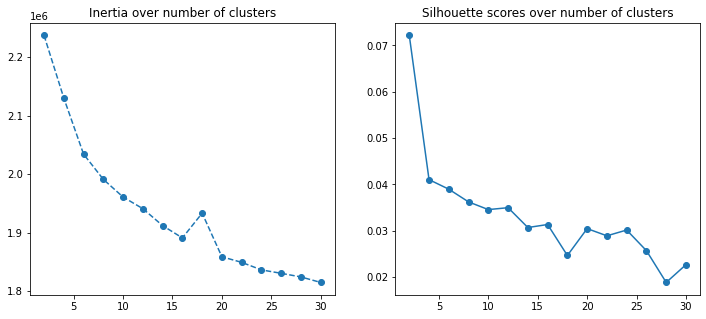

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(nc_list, inertias, '--o')
plt.title('Inertia over number of clusters')
plt.subplot(1, 2, 2)
plt.plot(nc_list, sil_scores, '-o')
plt.title('Silhouette scores over number of clusters');

We'll pick `10` as our preferred `n_clusters` based on the "Elbow rule"

In [22]:
# Recalculate pcs with full datasets
azdias_pcs = pca_pipeline.fit_transform(azdias)
customers_pcs = pca_pipeline.transform(customers[azdias.columns])

In [24]:
# Refit with best n_clusters
n_clusters = 10
clusterer = MiniBatchKMeans(n_clusters=n_clusters, verbose=1, random_state=42)
clusterer.fit(azdias_pcs)
print(clusterer.inertia_)

azdias_labels = pd.Series(clusterer.labels_, index=azdias.index)

clustering_pipeline = Pipeline([
    ('pca_pipeline', pca_pipeline),
    ('cluster', clusterer)
])

customers_labels = pd.Series(clustering_pipeline.predict(customers[azdias.columns]), index=customers.index)  # Without customer only columns

Init 1/3 with method: k-means++
Inertia for init 1/3: 8110.053283
Init 2/3 with method: k-means++
Inertia for init 2/3: 8146.599464
Init 3/3 with method: k-means++
Inertia for init 3/3: 8215.038409
Minibatch iteration 1/732800: mean batch inertia: 27.925448, ewa inertia: 27.925448 
Minibatch iteration 2/732800: mean batch inertia: 27.035078, ewa inertia: 27.925205 
Minibatch iteration 3/732800: mean batch inertia: 28.234431, ewa inertia: 27.925290 
Minibatch iteration 4/732800: mean batch inertia: 28.375098, ewa inertia: 27.925413 
Minibatch iteration 5/732800: mean batch inertia: 27.195198, ewa inertia: 27.925213 
Minibatch iteration 6/732800: mean batch inertia: 27.808562, ewa inertia: 27.925181 
Minibatch iteration 7/732800: mean batch inertia: 27.433491, ewa inertia: 27.925047 
Minibatch iteration 8/732800: mean batch inertia: 27.201708, ewa inertia: 27.924850 
Minibatch iteration 9/732800: mean batch inertia: 26.698352, ewa inertia: 27.924515 
Minibatch iteration 10/732800: mean b

,Customers,General Population
0,0.042784,0.072170
1,0.023831,0.115287
2,0.057599,0.109281
3,0.111090,0.107024
4,0.096923,0.092972
5,0.008398,0.117545
6,0.153881,0.083964
7,0.006630,0.114012
8,0.439018,0.128308
9,0.059847,0.059435


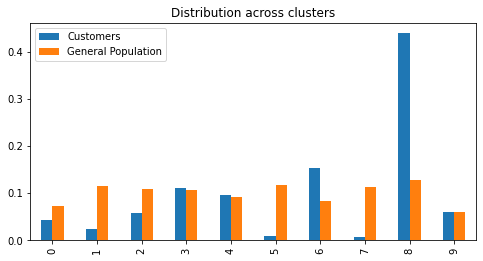

In [25]:
data = pd.concat([customers_labels.value_counts() / len(customers_labels), azdias_labels.value_counts() / len(azdias_labels)], axis=1)
data.columns = ['Customers', 'General Population']
data.plot.bar(figsize=(8, 4))
plt.title('Distribution across clusters');
data

Even though all clusters are somewhat uniformly distributed in the general population, cluster `78` dominates amongst our customers, followed by clusters `6`, `3` and `4`, respectively. All of these clusters are proportionally more represented in `customers` than in `azdias`.

A look at the principal components and their feature weights should aid in defining the key characteristics of the members of cluster `11`, which can be useful for business decisions and directed marketing campaigns.

In [26]:
cluster_pcs = pd.DataFrame(clusterer.cluster_centers_)
cluster_pcs

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,0.970008,1.733100,-1.512814,0.030390,0.698612,0.542653,0.042256,0.114719,-0.145562,-0.329190,...,0.005858,-0.030370,-0.013155,-0.016998,-0.003346,-0.015957,-0.007990,0.001042,0.001146,0.033345
1,-1.059054,-1.879074,-0.220228,0.254155,0.077493,0.042546,0.093450,-0.070326,0.036292,-0.063001,...,-0.008396,-0.010120,-0.011686,0.008777,-0.018525,0.004996,-0.004216,-0.013021,0.000829,0.011467
2,1.810233,1.397337,0.128067,0.188488,-0.191317,-0.750620,-0.136848,0.108009,0.051264,0.160475,...,-0.011847,0.015387,-0.005514,-0.009632,-0.014643,0.010265,0.004513,-0.007995,0.013606,0.016482
3,-0.387736,1.160882,0.353014,-0.658784,-0.577851,0.088842,-0.337406,0.040090,0.105951,-0.431987,...,0.014056,-0.014276,-0.002760,-0.018246,0.000802,-0.009702,0.004212,-0.011718,0.003370,-0.000382
4,-1.692392,0.529493,-1.000016,0.109332,-1.053117,-0.119673,0.357223,0.093536,0.057227,0.225635,...,-0.012755,0.055570,-0.012518,0.005729,0.023204,-0.026701,0.007513,-0.016005,0.013756,-0.007129
5,2.693437,-0.993187,-0.176771,0.161895,0.340935,0.068767,0.126445,-0.189738,-0.148828,0.157646,...,0.020439,-0.007888,-0.006973,0.025279,0.029575,0.001197,0.002518,-0.006235,-0.010421,-0.019912
6,-1.999547,-0.187454,-0.916865,-0.099934,0.491656,-0.869686,0.366814,0.047483,0.207411,-0.023381,...,-0.002590,-0.025339,0.012920,-0.018394,-0.035163,0.031659,0.015551,0.035825,0.015158,-0.001757
7,0.742902,-1.598467,0.084195,-0.525752,-0.547132,0.362915,-0.392411,-0.138285,-0.014829,-0.403611,...,-0.010160,0.000207,0.013803,-0.006943,-0.002578,-0.000607,-0.007077,0.017294,-0.022596,-0.014626
8,-1.994279,0.443210,1.093860,0.246124,0.783663,0.382587,-0.337034,0.020698,-0.233248,0.508581,...,0.010550,0.012283,0.007888,-0.001014,0.008631,-0.005554,-0.001354,0.000649,-0.012650,-0.008479
9,0.899291,0.261968,2.313366,0.374582,0.053893,0.162687,0.766331,0.095062,0.299871,0.108381,...,-0.022352,-0.000293,0.010127,0.037853,-0.000139,0.024897,-0.020521,0.017407,0.013184,-0.000231


In [29]:
def get_top_cluster_features(cluster_centers_, cluster_id, top_n=5):
    """Returns the `top_n` most influential features in a given cluster"""
    
    cluster_centers = pd.DataFrame(cluster_centers_)
    cluster_pcs = cluster_centers.loc[4]
    return cluster_pcs[cluster_pcs.abs().sort_values(ascending=False).head(top_n).index]
    
customers_majority_cluster = 8
top5_components = get_top_cluster_features(clusterer.cluster_centers_, customers_majority_cluster)
top5_components

0   -1.692392
4   -1.053117
2   -1.000016
1    0.529493
6    0.357223
Name: 4, dtype: float64

,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,...,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ALTERSKATEGORIE_GROB
0,-0.014616,0.014616,-0.004391,-0.001903,-0.001875,-0.009814,-0.002785,-0.009524,-0.010120,-0.014106,...,-0.003786,0.018558,-0.026426,0.029104,0.050418,0.056468,0.060675,0.033294,-0.025874,-0.058724
4,-0.082644,0.082644,0.001846,0.000672,0.001820,0.006956,0.002610,0.001651,0.000102,0.003744,...,0.061038,0.016150,0.053084,-0.010518,-0.161307,-0.151816,-0.129551,-0.153783,0.019289,-0.002276
2,0.007352,-0.007352,0.006805,0.002265,0.003714,0.010271,0.006308,0.002987,-0.003843,-0.001058,...,0.007969,0.015616,-0.010718,0.037175,-0.002445,0.001874,0.007548,-0.001700,-0.007172,-0.021040
1,0.012301,-0.012301,-0.000022,-0.000044,0.000466,0.000590,0.000680,-0.004873,-0.003150,-0.003786,...,-0.025617,0.008931,0.002889,0.021691,0.053973,0.013463,-0.022294,0.100740,0.031561,0.173619
6,-0.021731,0.021731,0.001336,-0.001366,0.001302,-0.003352,0.001070,-0.001821,0.004737,0.001063,...,-0.004473,-0.009834,0.008319,0.014368,-0.018148,-0.020409,-0.022342,-0.002308,-0.005690,0.008458


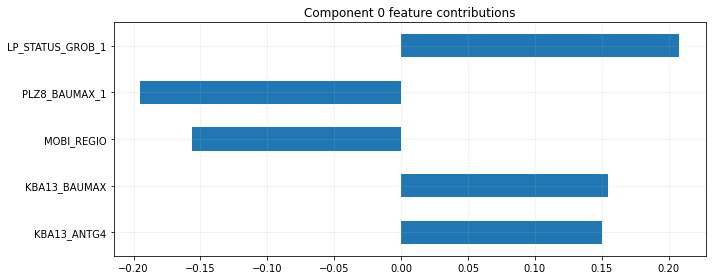

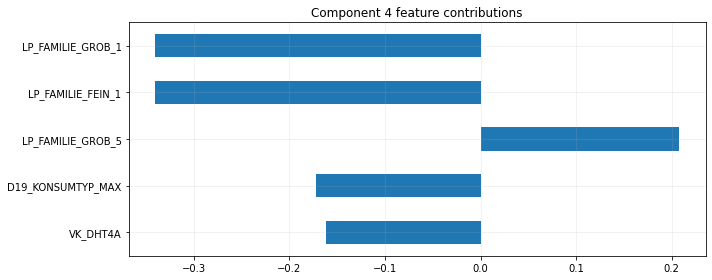

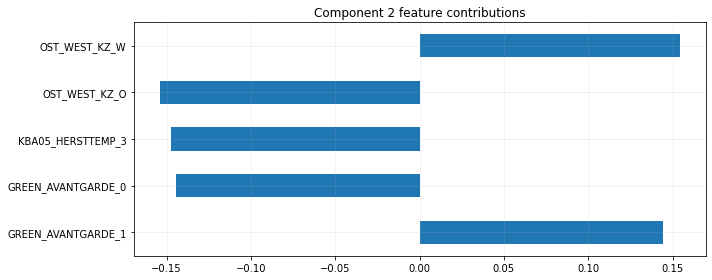

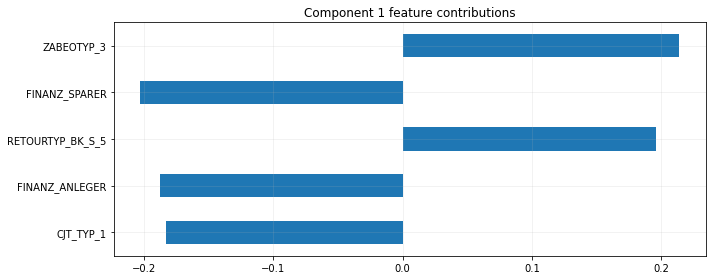

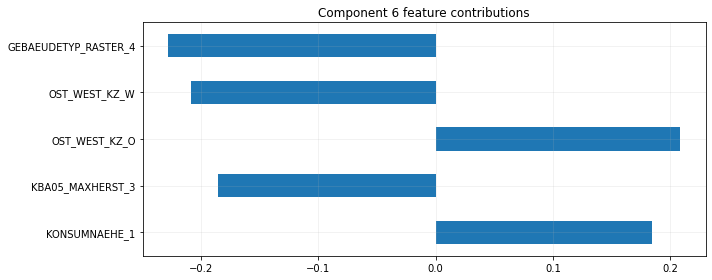

In [30]:
# Retrieve column names from one hot encoder
col_names = []
for name in pca_pipeline.steps[0][1].get_feature_names():
    if 'one_hot__' in name:
        col_index = int(name.strip('one_hot__x').split('_')[0])
        col_value = name.split('_')[-1]
        col_names.append(f'{cat_cols[0].tolist()[col_index]}_{col_value}')
    else:
        col_names.append(name)

def plot_feature_influence_in_pcs(fitted_pca, component_indices, col_names=col_names, plot_top_n=5):
    """
        Constructs a pandas.DataFrame of principal components and their feature contributions,
        then plots a feature contribution graph for each of the components indicated in 
        `component_indices`.
    """
    components_df = pd.DataFrame(fitted_pca.components_[component_indices], index=component_indices)
    components_df.columns = col_names
    for i, row in components_df.iterrows():
        fig = plt.figure(figsize=(10, 4))
        row[row.abs().sort_values().index].tail(plot_top_n).plot.barh()
        plt.title(f'Component {row.name} feature contributions')
        fig.tight_layout()
        plt.grid('on', alpha=0.2)
    return components_df
        
plot_feature_influence_in_pcs(pca_pipeline.steps[-1][1], top5_components.index)

The cluster center + principal component analysis indicate that the features most responsible for the segmentation between customers and general public are the same features found using the KS test to check for distribution differences.

In [31]:
# Dump the fitted clustering pipeline for later use
dump(clustering_pipeline, 'models/clustering_pipeline.joblib')
dump(clusterer, 'models/clusterer.joblib')

['models/clusterer.joblib']